## Exam 08/06/2021
### Plans 1 and 3
Alessandro Lodi<br>
Matricola 274425

This problems can be formulated as ATSP

### Notebook Init

In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class args:
    filename = "2_distnet08062021.gml"
    scale = 40
    figsize = 20,20

### Drawing functions

In [4]:
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()

In [5]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 27 nodes and 702 edges


## ATSP compact formulation

### Miller-Tucker-Zemlin lifted formulation (Desrochers-Laporte)
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
u_i - u_j + (n-1)x_{ij} + (n-3)x_{ji} &\le n-2 \;\; \forall (i,j) \in A, i\not=1,j\not=1 \;\; \text{(MTZ)}\\
x & \in \{0,1\}^{|A|}\\
u_1 &= 1\\
2 &\le u_i \le n \;\; \forall i \in N, i \not = \{1\}
\end{alignat}
$$

## Plan 1

In [6]:
root=1

atsp_mtz = gb.Model()

x = atsp_mtz.addVars(G.edges(),
                     obj=[G[i][j]['dist'] for i,j in G.edges()],
                     vtype=gb.GRB.BINARY, name='x')

u = atsp_mtz.addVars(G.nodes(), 
                     obj=[0.0 for i in G.nodes()],
                     lb=2.0, ub=G.number_of_nodes(), 
                     vtype=gb.GRB.CONTINUOUS,
                     name='u')

atsp_mtz.addConstrs((x.sum(i,'*') == 1 for i in G.nodes()), name='FS')
atsp_mtz.addConstrs((x.sum('*',i) == 1 for i in G.nodes()), name='RS')

# Fixing root node
u[root].lb = 1.0
u[root].ub = 1.0


atsp_mtz.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)
                   for i in G.nodes() for j in G.nodes()
                   if (i != j) and (i != root) and (j !=root) and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

Academic license - for non-commercial use only - expires 2021-08-02
Using license file /opt/gurobi/gurobi.lic


In [7]:
atsp_mtz.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 704 rows, 729 columns and 4004 nonzeros
Model fingerprint: 0x16e45b1a
Variable types: 27 continuous, 702 integer (702 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 704 rows, 728 columns, 4004 nonzeros
Variable types: 26 continuous, 702 integer (702 binary)
Found heuristic solution: objective 45571.000000

Root relaxation: objective 1.336958e+04, 112 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 13369.5816    0   34 45571.0000 13369.5816  70.7%     -    0s
H    0     0                    18436.000000 13

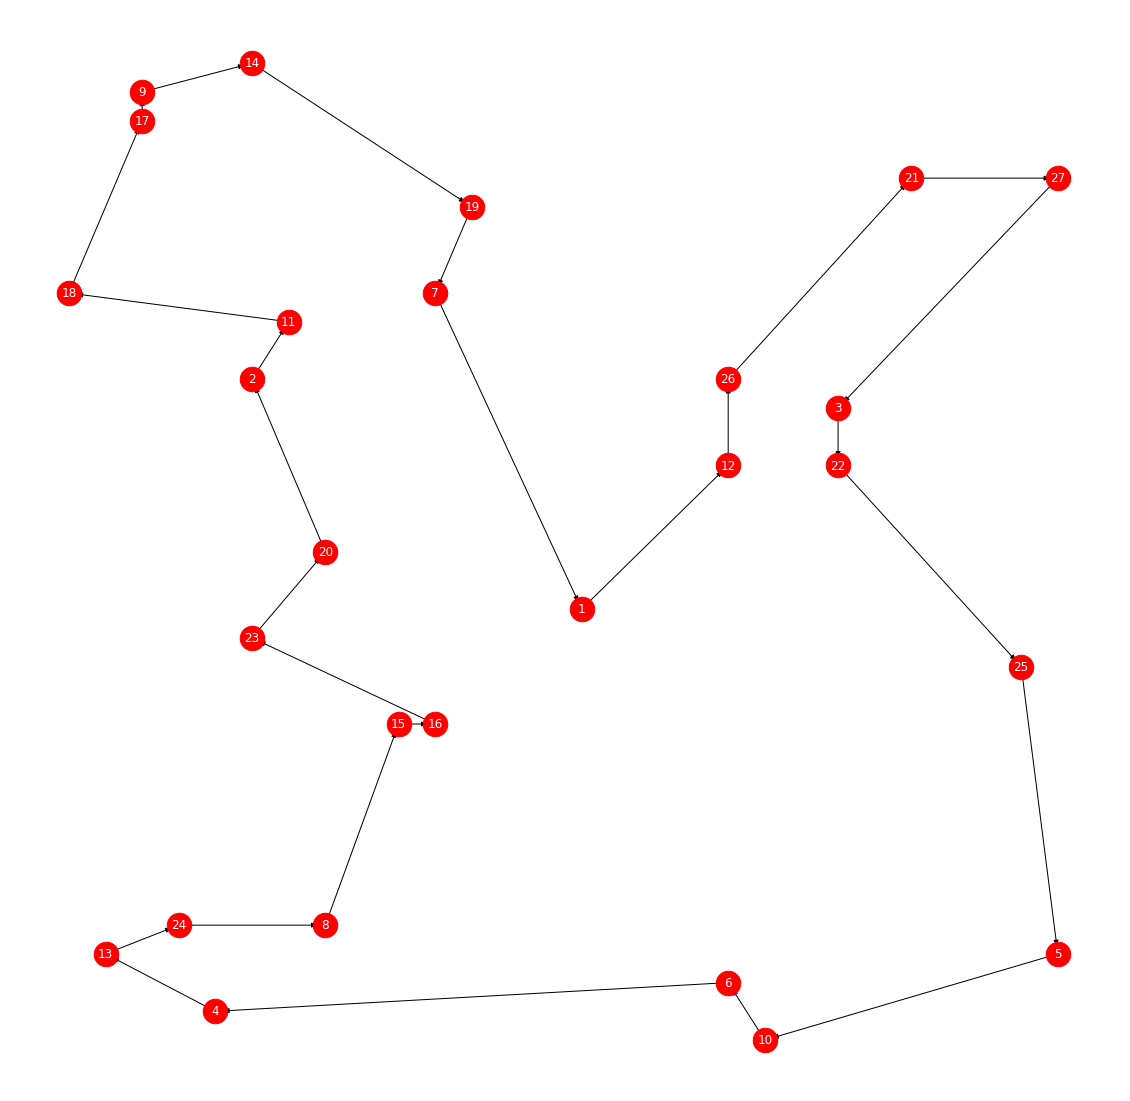

In [8]:
DrawSol(G,x)

In [9]:
print("The total cost is", atsp_mtz.objVal+4550)

The total cost is 19631.0


- Optimal solution: 1.508100000000e+04
- Value of the linear relaxation: 1.336958e+04
- Number of enumerated nodes: 17812 

## Plan 3

In this case we deliver using a vehicle with capacity $C=15$. This means that the intermediate stop in the warehouse 
at node 16 must occurs not after the visit of 15 nodes (root excluded) and not before the visit of 11 nodes (26-15).

In [10]:
u[20].lb = 11.0
u[20].ub = 16.0
atsp_mtz.update()

In [11]:
atsp_mtz.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 704 rows, 729 columns and 4004 nonzeros
Model fingerprint: 0x3305f2f4
Variable types: 27 continuous, 702 integer (702 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 704 rows, 728 columns, 4004 nonzeros
Variable types: 26 continuous, 702 integer (702 binary)

Root relaxation: objective 1.336958e+04, 118 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 13369.5816    0   34          - 13369.5816      -     -    0s
H    0     0           

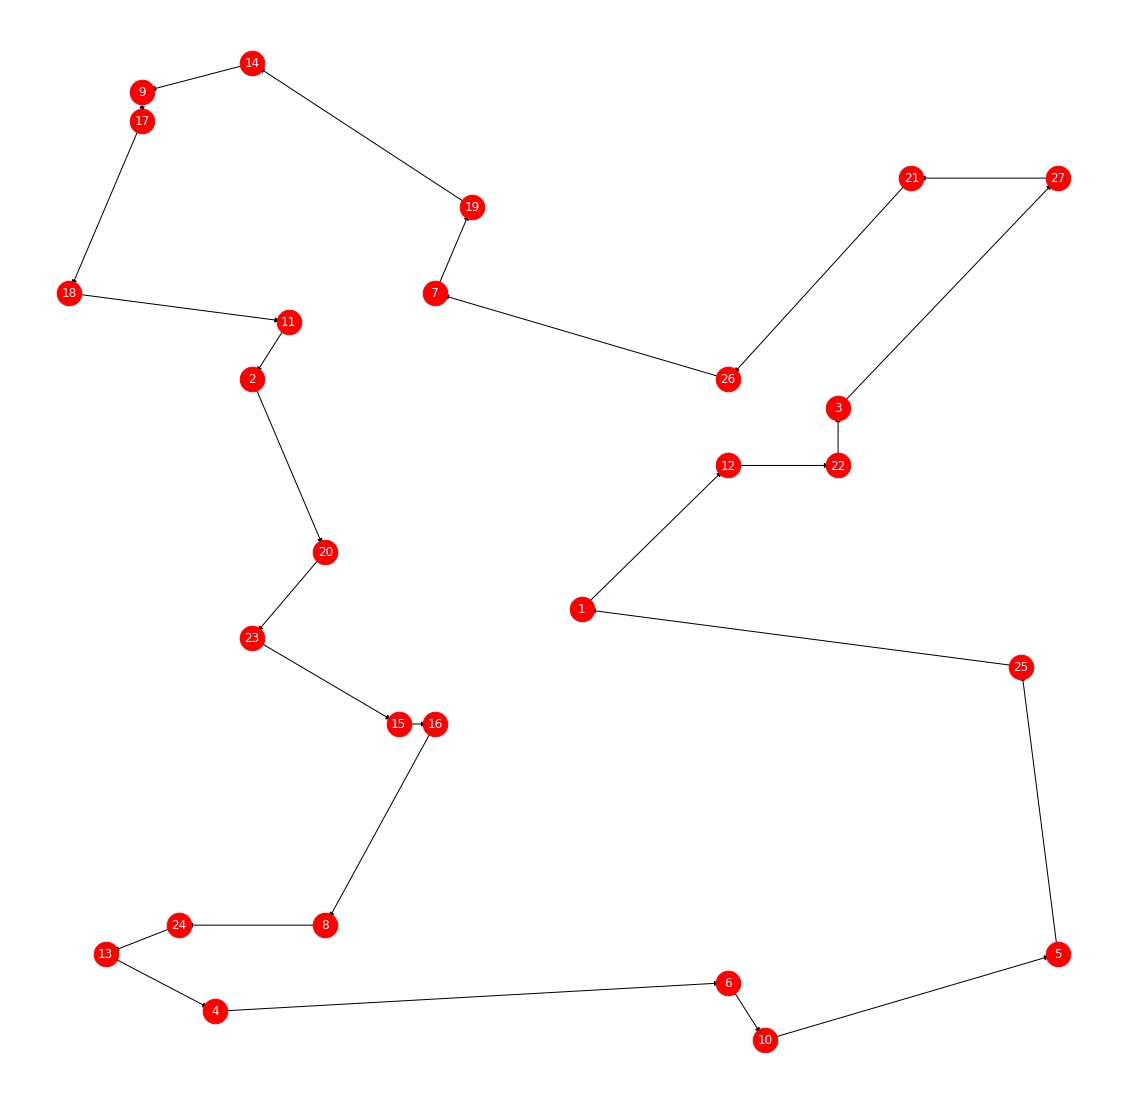

In [12]:
DrawSol(G,x)

In [13]:
print("The total cost is", atsp_mtz.objVal +1400 +2300)

The total cost is 18994.0


- Optimal solution: 1.529400000000e+04
- Value of the linear relaxation: 1.336958e+04
- Number of enumerated nodes: 51575  